In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv' , index_col= 'Id')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col= 'Id')

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
X = train.drop('SalePrice',axis=1)
y = train['SalePrice']

In [7]:
numerical_cols = [col for col in X.columns if X[col].dtype in ['float64','int64']]

In [8]:
ordinal_cols = ['MSZoning','LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

In [9]:
nominal_cols = ['Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2','HouseStyle','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','Electrical','GarageType','MiscFeature','SaleType','SaleCondition']

In [10]:
train_num = train[numerical_cols].copy()
train_ord = train[ordinal_cols].copy()
train_nom = train[nominal_cols].copy()

In [11]:
def find_nan_cols(df):
    null = df.isnull().sum()
    missing_df = pd.concat([null], axis=1, keys=['nancount'])
    return missing_df[(missing_df.nancount > 0)]

## Preprocessing for numerical columns 

In [12]:
find_nan_cols(train_num)

,nancount
LotFrontage,259
MasVnrArea,8
GarageYrBlt,81


In [13]:
train_num.drop(['LotFrontage','GarageYrBlt'],axis=1,inplace=True) # i'll delete columns that have missing values > 5%

In [14]:
numerical_cols = train_num.columns # updating numerical cols 

In [15]:
# saving columns medians in meds dictionary after filling them. 
def Fill_num(df):
    meds = {}
    for col in find_nan_cols(df).index :
        df.fillna(df[col].median(),inplace=True)
        meds[col] = df[col].median()
    return meds

In [16]:
meds = Fill_num(train_num)

In [17]:
## Features Selection 

from sklearn.feature_selection import mutual_info_regression as MIR
mi_score = MIR(np.array(train_num),y.ravel())

In [18]:
mi_score

array([0.27132964, 0.1609512 , 0.56060787, 0.11277919, 0.37151335,
       0.2473976 , 0.08908939, 0.14945937, 0.        , 0.11573687,
       0.36561847, 0.30930041, 0.19346397, 0.        , 0.48060608,
       0.02391544, 0.00807127, 0.25987216, 0.08632189, 0.06444198,
       0.02995021, 0.22036887, 0.16675344, 0.36158855, 0.36747638,
       0.09636828, 0.14525969, 0.02337301, 0.00315817, 0.0103864 ,
       0.        , 0.00441507, 0.        , 0.        ])

In [19]:
mi_score_selected_index = np.where(mi_score >0.2)[0]
mi_score_selected_index

array([ 0,  2,  4,  5, 10, 11, 14, 17, 21, 23, 24])

In [20]:
train_num_ = train_num.iloc[:,mi_score_selected_index]

<AxesSubplot:>

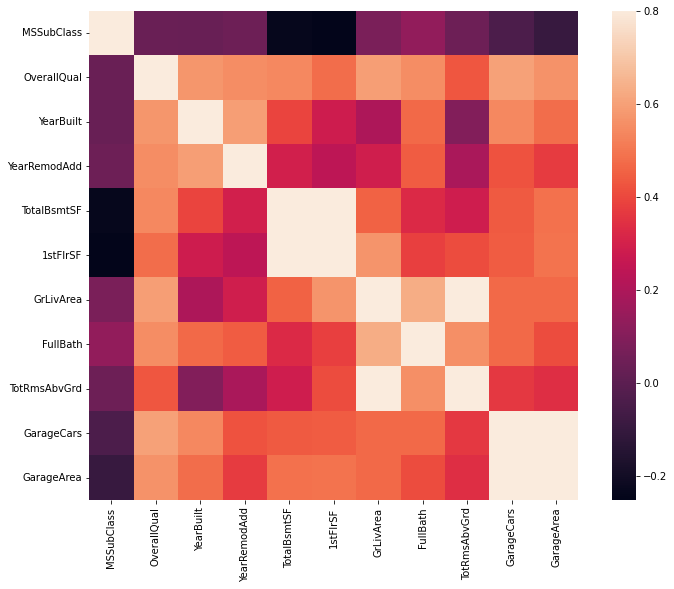

In [21]:
#correlation matrix for selected features
corrmat = train_num_.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [22]:
numerical_final_cols = ['OverallQual','YearBuilt','TotalBsmtSF','GrLivArea','FullBath','GarageCars']

In [23]:
train_num_array = np.array(train_num[numerical_final_cols])

## Preproccesing for Ordinal Columns 

In [24]:
def Fill_ord(df):
    mods = {}
    some_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC','Fence']
    for col in find_nan_cols(df).index :
        if col in some_cols:
            df[col] = df[col].replace(np.nan,'NOTFOUND')
        else:
            df[col] = df[col].replace(np.nan,df[col].mode()[0])
            mods[col] = df[col].mode()[0]
    return mods

In [25]:
mods = Fill_ord(train_ord)

In [26]:
from sklearn.preprocessing import OrdinalEncoder
def OrdinalEncoding(col,cat):
    ord_enc = OrdinalEncoder(categories = [cat])
    return ord_enc.fit_transform(col)

In [27]:
def Ordinal_Encoding(df):
    categories = {'MSZoning' : ['A','C (all)','FV','I','RH','RL','RP','RM'],
              'LotShape' : ['IR3','IR2','IR1','Reg'],
              'Utilities' : ['ELO','NoSeWa','NoSewr','AllPub'],
             'LandSlope' : ['Sev','Mod','Gtl'],
             'ExterQual' : ['Po','Fa','TA','Gd','Ex'],
             'ExterCond' : ['Po','Fa','TA','Gd','Ex'],
             'BsmtQual' : ['NOTFOUND','Po','Fa','TA','Gd','Ex'],
             'BsmtCond' : ['NOTFOUND','Po','Fa','TA','Gd','Ex'],
             'BsmtExposure' : ['NOTFOUND','No','Mn','Av','Gd'],
             'BsmtFinType1' : ['NOTFOUND','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
             'BsmtFinType2' : ['NOTFOUND','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
             'HeatingQC' : ['Po','Fa','TA','Gd','Ex'],
             'KitchenQual' : ['Po','Fa','TA','Gd','Ex'],
             'Functional' : ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
             'FireplaceQu' : ['NOTFOUND','Po','Fa','TA','Gd','Ex'],
             'GarageFinish' : ['NOTFOUND','Unf','RFn','Fin'],
             'GarageQual' : ['NOTFOUND','Po','Fa','TA','Gd','Ex'],
             'GarageCond' : ['NOTFOUND','Po','Fa','TA','Gd','Ex'],
             'PavedDrive' : ['N','P','Y'],
             'PoolQC' : ['NOTFOUND','Fa','TA','Gd','Ex'],
             'Fence'  : ['NOTFOUND','MnWw','GdWo','MnPrv','GdPrv']}
    for col in df.columns :
        df[col] = OrdinalEncoding(df[[col]],categories[col])

In [28]:
Ordinal_Encoding(train_ord)

In [29]:
oridnal_cols_final = ['Utilities','ExterQual','BsmtQual','KitchenQual','FireplaceQu','GarageFinish','PoolQC',]

In [30]:
train_ord_array = np.array(train_ord[oridnal_cols_final])

## Preprocessing for Nominal columns 

In [31]:
def Fill_nom(df):
    for col in find_nan_cols(df).index :
        df[col] = df[col].replace(np.nan,df[col].mode()[0])

In [32]:
Fill_nom(train_nom)

In [33]:
nominal_cols_final = ['Street','Neighborhood','Condition1','HouseStyle','BldgType','RoofStyle','Exterior1st','MasVnrType','Heating','CentralAir','Electrical','SaleType',
 'SaleCondition']

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
    
oh_enc = OneHotEncoder(sparse = False)
column_transform = make_column_transformer(
        (oh_enc,nominal_cols_final))
column_transform.fit(train_nom)
def one_hot_encoding(df,column_transform):
    return column_transform.transform(df)


In [35]:
train_nom_arr = one_hot_encoding(train_nom,column_transform)

## Combining all columns 

In [36]:
X_train_ = np.c_[train_num_array,train_ord_array,train_nom_arr]

In [37]:
# scaling 
from sklearn.preprocessing import StandardScaler 
X_train_scaled = StandardScaler().fit_transform(X_train_)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)

## ML MODEL

In [39]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


model = XGBRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(np.log(y_test), np.log(pred))))

In [40]:
rmse

0.15967507878360804

## test part

In [41]:
test_num = test[numerical_final_cols].copy()
test_ord = test[oridnal_cols_final].copy()
test_nom = test[nominal_cols_final].copy()

In [42]:
for col in find_nan_cols(test_ord).index :
    if col in list(mods.keys()) :
        test_ord[col] = test_ord[col].replace(np.nan,mods[col])
    elif col in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC','Fence'] :
        test_ord[col] = test_ord[col].replace(np.nan,'NOTFOUND')
    else:
        test_ord[col] = test_ord[col].replace(np.nan,test_ord[col].mode()[0])

In [43]:
Fill_nom(test_nom)

In [44]:
for col in find_nan_cols(test_num).index :
    if col in list(meds.keys()) :
        test_num[col] = test_num[col].replace(np.nan,meds[col])
    else:
        test_num[col] = test_num[col].replace(np.nan,test_num[col].median())

In [45]:
test_num_arr = np.array(test_num)

indices = test_num.index

Ordinal_Encoding(test_ord)
test_ord_arr = np.array(test_ord)

test_nom_arr = one_hot_encoding(test_nom,column_transform)

In [46]:
X_Test_ = np.c_[test_num_arr,test_ord_arr,test_nom_arr]

In [47]:
preds_test = model.predict(X_Test_)

In [48]:
output = pd.DataFrame({'Id': indices,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)